In [1]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import re
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
import nltk

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set([
    'અને', 'તે', 'છે', 'હવે', 'કે', 'આ', 'તેથી', 'કેમકે', 'તેમજ', 'માટે', 'પણ', 'તો', 'જ',
    'જે', 'હા', 'કહે', 'હમણાં', 'તેને', 'ની', 'માં', 'વખતે', 'પર', 'એ', 'કોઈ', 'સુધી', 'હવે','અમે', 'અન્ય', 'અંદર', 'અથવા', 'અત્યારે', 'અને', 'અપેક્ષા', 'અપેક્ષિત', 'અનુકૂળ', 'અનુસાર', 'અહીં', 'આ', 'આવી', 'આવું',
                      'આખું', 'આખી', 'આમ', 'આમણે', 'આમને', 'આયુર્વેદ', 'આરંભે', 'આને', 'આપ', 'આપણે', 'આપણું', 'આપણો', 'આપવાનો', 'આપી',
                      'આવી', 'આવું', 'આવવું', 'આશરે', 'આશ્ચર્ય', 'આશ્રિત', 'આસપાસ', 'આહ', 'આહવાળું', 'ઇત્યાદિ', 'ઈ', 'ઉપર', 'ઉપરાંત',
                      'ઉપરથી', 'ઉપરોક્ત', 'ઉલ્લેખ', 'એ', 'એમ', 'એમના', 'એમણે', 'એમને', 'એમની', 'એક', 'એને', 'એવી', 'એવું', 'ઓ', 'ઓહો', 'કંઈ',
                      'કઈ', 'કઈક', 'કહેવાય', 'કહેવાય છે', 'કઈંક', 'કહેવું', 'કઈ', 'કેમ', 'કેટલો', 'કેટલું', 'કેટલી', 'કેટલાક', 'કેટલીક',
                      'કોઇ', 'કોઈ', 'કોઈક', 'કોઈને', 'કોઈપણ', 'ક્યારે', 'ક્યારેક', 'ક્યારેય', 'ક્યાં', 'ક્યાંય', 'ક્યાંક', 'ખરેખર', 'ખરું',
                      'ખૂબ', 'ગયા', 'ઘણાં', 'ઘણી', 'ઘણું', 'ઘણો', 'જ', 'જ્યાં', 'જ્યારે', 'જ્યાંય', 'જ્યાંક', 'તમે', 'તમે', 'તમારા', 'તારું',
                      'તમારું', 'તમારા', 'તમારી', 'તેમ', 'તેમના', 'તેમણે', 'તેમને', 'તેમની', 'તેમ', 'તે', 'તેના', 'તેણે', 'તેને', 'તેમજ',
                      'તેઓ', 'તેથી', 'તેનાથી', 'ત્યાં', 'ત્યાંથી', 'ત્યાંય', 'ત્યાંક', 'થઈ', 'થઈને', 'થયું', 'થાય', 'થાય છે', 'થાતું',
                      'થાતી', 'થાતો', 'થોડું', 'થોડી', 'થોડો', 'ન', 'નઆ', 'નહીં', 'નકામું', 'નકામી', 'નકામો', 'નના', 'નને', 'નથી', 'નબળું',
                      'નબળી', 'નબલો', 'પર', 'પરંતુ', 'પરમ', 'પર્યાપ્ત', 'પણ', 'ફરી', 'બને', 'બન્યું', 'બજાય', 'બીજું', 'બીજું કંઈક', 'બધા',
                      'બધું', 'બધું જ', 'બધે', 'બહુ', 'મકાન', 'મુકતો', 'મુકી', 'મુલ્ય', 'મારું', 'મારી', 'મારો', 'માટે', 'માટેનું', 'માથે', 'મુલક',
                      'મૂળ', 'મૂળભૂત', 'મુજ', 'મહત્વનું', 'મહત્વનો', 'મહત્વની', 'મહત્ત્વનો', 'મહિલા', 'મહિલાઓ', 'માત્ર', 'યાદ', 'યુદ્ધ', 'યુવા',
                      'યુવકો', 'રમત', 'રહશે', 'રહેવું', 'રહ્યો', 'રહે', 'રહે છે', 'લગભગ', 'લાખ', 'વગેરે', 'વગેરના', 'વગેરે', 'વહાણ', 'વહેલી',
                      'વર્તમાન', 'વર્તમાનમાં', 'વરસાદ', 'વહેંચવું', 'સંગઠન', 'સંભવ', 'સંભવત', 'સંભવત', 'સકાય', 'સજ્જ', 'સમાન', 'સંતુલન', 'સફળ',
                      'સફળતા', 'સફળતાપૂર્વક', 'સફળતાથી', 'સફળતાવાળી', 'સફળતાવાળો', 'સફળતાવાળી'
])

# Load the dataset
file_path = 'shuffled_augmented_poetry_dataset.csv'  # Update the file path if necessary
poetry_data = pd.read_csv('gujrati.csv')

# Preprocessing Function for Text Normalization
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove special characters and punctuation (keeping alphabet and spaces)
    text = re.sub(r'[^\u0A80-\u0AFF ]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text preprocessing to the 'Sentence' column
poetry_data['Sentence'] = poetry_data['Sentence'].apply(preprocess_text)

# Remove stopwords from the sentences
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

poetry_data['Sentence'] = poetry_data['Sentence'].apply(remove_stopwords)

# Optional: Remove short and long sentences (based on word count)
poetry_data = poetry_data[poetry_data['Sentence'].apply(lambda x: 3 < len(x.split()) < 50)]

# Handling class imbalance for sentiment (Oversampling minority classes)
sentiment_counts = poetry_data['Sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resampling the minority class
minority_class = poetry_data[poetry_data['Sentiment'] == min_class]
majority_class = poetry_data[poetry_data['Sentiment'] != min_class]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,    # Sample with replacement
                              n_samples=len(majority_class), # Match majority class
                              random_state=42)

# Combine the upsampled minority class with the majority class
poetry_data_balanced = pd.concat([majority_class, minority_upsampled])

# Ensure your dataset has the 'Sentence', 'Sentiment', and 'Emotion' columns
hf_dataset_sentiment = Dataset.from_pandas(poetry_data_balanced[['Sentence', 'Sentiment']])
hf_dataset_emotion = Dataset.from_pandas(poetry_data_balanced[['Sentence', 'Emotion']])

# Map sentiment labels (adjust based on your dataset)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

# Updated emotion mapping based on unique values in your dataset
emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

# Map the labels to numerical values
hf_dataset_sentiment = hf_dataset_sentiment.map(lambda x: {'labels': sentiment_label_mapping[x['Sentiment']]})
hf_dataset_emotion = hf_dataset_emotion.map(lambda x: {'labels': emotion_label_mapping[x['Emotion']]})

# Tokenizer
sentiment_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Tokenize the dataset with reduced sequence length
def tokenize_sentiment(example):
    return sentiment_tokenizer(example['Sentence'], padding="max_length", truncation=True, max_length=128)

def tokenize_emotion(example):
    return emotion_tokenizer(example['Sentence'], padding="max_length", truncation=True, max_length=128)

hf_dataset_sentiment = hf_dataset_sentiment.map(tokenize_sentiment, batched=True)
hf_dataset_emotion = hf_dataset_emotion.map(tokenize_emotion, batched=True)

# Load pre-trained models and send them to the GPU if available
sentiment_model = RobertaForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=3
).to(device)

emotion_model = AutoModelForSequenceClassification.from_pretrained(
    "bhadresh-savani/distilbert-base-uncased-emotion",
    num_labels=len(emotion_label_mapping),
    ignore_mismatched_sizes=True
).to(device)

# Freeze lower layers of the models for faster training
for param in sentiment_model.roberta.embeddings.parameters():
    param.requires_grad = False  # Freeze embedding layer

for param in sentiment_model.roberta.encoder.layer[:6].parameters():
    param.requires_grad = False  # Freeze the first 6 layers of the encoder

# Compute metrics for evaluation using scikit-learn
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments for sentiment analysis with optimizations
training_args_sentiment = TrainingArguments(
    output_dir="./sentiment_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    gradient_accumulation_steps=4,  # Gradient accumulation
    fp16=True,  # Mixed precision training
    lr_scheduler_type="cosine"  # Cosine decay learning rate scheduler
)

# Training arguments for emotion analysis with optimizations
training_args_emotion = TrainingArguments(
    output_dir="./emotion_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    gradient_accumulation_steps=4,  # Gradient accumulation
    fp16=True,  # Mixed precision training
    lr_scheduler_type="cosine"  # Cosine decay learning rate scheduler
)

# Trainer for sentiment analysis
trainer_sentiment = Trainer(
    model=sentiment_model,
    args=training_args_sentiment,
    train_dataset=hf_dataset_sentiment,
    eval_dataset=hf_dataset_sentiment,
    tokenizer=sentiment_tokenizer,
    compute_metrics=compute_metrics
)

# Trainer for emotion analysis (continued)
trainer_emotion = Trainer(
    model=emotion_model,
    args=training_args_emotion,
    train_dataset=hf_dataset_emotion,
    eval_dataset=hf_dataset_emotion,
    tokenizer=emotion_tokenizer,
    compute_metrics=compute_metrics
)

# Fine-tune the models
trainer_sentiment.train()
trainer_emotion.train()

# Save the fine-tuned models
sentiment_model.save_pretrained('./fine_tuned_sentiment_model')
emotion_model.save_pretrained('./fine_tuned_emotion_model')

# Evaluate the models on the dataset
sentiment_results = trainer_sentiment.evaluate()
emotion_results = trainer_emotion.evaluate()

print("Sentiment Analysis Results:", sentiment_results)
print("Emotion Analysis Results:", emotion_results)


Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Map:   0%|          | 0/266664 [00:00<?, ? examples/s]

Map:   0%|          | 0/266664 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/266664 [00:00<?, ? examples/s]

Map:   0%|          | 0/266664 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnin

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.034700,0.039290,0.987670,0.991155,0.984062,0.987432


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,2.096800,2.044979,0.224841,0.131000,0.159993,0.108052


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Sentiment Analysis Results: {'eval_loss': 0.0392904207110405, 'eval_accuracy': 0.9876698766987669, 'eval_precision': 0.9911554078274536, 'eval_recall': 0.9840623406234063, 'eval_f1': 0.9874321118823555, 'eval_runtime': 335.1358, 'eval_samples_per_second': 795.689, 'eval_steps_per_second': 49.732, 'epoch': 0.999820003599928}
Emotion Analysis Results: {'eval_loss': 2.044978618621826, 'eval_accuracy': 0.2248409984099841, 'eval_precision': 0.1310001184941987, 'eval_recall': 0.15999305256002608, 'eval_f1': 0.10805247115945871, 'eval_runtime': 191.522, 'eval_samples_per_second': 1392.342, 'eval_steps_per_second': 87.024, 'epoch': 0.999820003599928}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
# import torch
# from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# from datasets import Dataset
# import pandas as pd
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# # Load the dataset
# file_path = 'final_poetry_dataset_no_duplicates.csv'  # Update the file path if necessary
# poetry_data = pd.read_csv(file_path)

# # Ensure your dataset has the 'Sentence', 'Sentiment', and 'Emotion' columns
# hf_dataset_sentiment = Dataset.from_pandas(poetry_data[['Sentence', 'Sentiment']])
# hf_dataset_emotion = Dataset.from_pandas(poetry_data[['Sentence', 'Emotion']])

# # Map sentiment labels (adjust based on your dataset)
# sentiment_label_mapping = {
#     'Negative': 0,
#     'Neutral': 1,
#     'Positive': 2
# }

# # Updated emotion mapping based on unique values in your dataset
# emotion_label_mapping = {
#     'Joy': 0,
#     'Peace': 1,
#     'Love': 2,
#     'Anger': 3,
#     'Hope': 4,
#     'Calm': 5,
#     'Grief': 6,
#     'Acceptance': 7,
#     'Sadness': 8,
# }

# # Map the labels to numerical values
# hf_dataset_sentiment = hf_dataset_sentiment.map(lambda x: {'labels': sentiment_label_mapping[x['Sentiment']]})
# hf_dataset_emotion = hf_dataset_emotion.map(lambda x: {'labels': emotion_label_mapping[x['Emotion']]})

# # Tokenizer
# sentiment_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
# emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# # Tokenize the dataset with reduced sequence length
# def tokenize_sentiment(example):
#     return sentiment_tokenizer(example['Sentence'], padding="max_length", truncation=True, max_length=128)

# def tokenize_emotion(example):
#     return emotion_tokenizer(example['Sentence'], padding="max_length", truncation=True, max_length=128)

# hf_dataset_sentiment = hf_dataset_sentiment.map(tokenize_sentiment, batched=True)
# hf_dataset_emotion = hf_dataset_emotion.map(tokenize_emotion, batched=True)

# # Load pre-trained models and send them to the GPU if available
# sentiment_model = RobertaForSequenceClassification.from_pretrained(
#     "cardiffnlp/twitter-roberta-base-sentiment",
#     num_labels=3
# ).to(device)

# emotion_model = AutoModelForSequenceClassification.from_pretrained(
#     "bhadresh-savani/distilbert-base-uncased-emotion",
#     num_labels=len(emotion_label_mapping),
#     ignore_mismatched_sizes=True
# ).to(device)

# # Freeze lower layers of the models for faster training
# for param in sentiment_model.roberta.embeddings.parameters():
#     param.requires_grad = False  # Freeze embedding layer

# for param in sentiment_model.roberta.encoder.layer[:6].parameters():
#     param.requires_grad = False  # Freeze the first 6 layers of the encoder

# # Compute metrics for evaluation using scikit-learn
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     accuracy = accuracy_score(labels, preds)
#     precision = precision_score(labels, preds, average='macro')
#     recall = recall_score(labels, preds, average='macro')
#     f1 = f1_score(labels, preds, average='macro')
#     return {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1
#     }

# # Training arguments for sentiment analysis with optimizations
# training_args_sentiment = TrainingArguments(
#     output_dir="./sentiment_results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=1,  # Reduced number of epochs
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     gradient_accumulation_steps=4,  # Gradient accumulation
#     fp16=True,  # Mixed precision training
#     lr_scheduler_type="cosine"  # Cosine decay learning rate scheduler
# )

# # Training arguments for emotion analysis with optimizations
# training_args_emotion = TrainingArguments(
#     output_dir="./emotion_results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=1,  # Reduced number of epochs
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     gradient_accumulation_steps=4,  # Gradient accumulation
#     fp16=True,  # Mixed precision training
#     lr_scheduler_type="cosine"  # Cosine decay learning rate scheduler
# )

# # Trainer for sentiment analysis
# trainer_sentiment = Trainer(
#     model=sentiment_model,
#     args=training_args_sentiment,
#     train_dataset=hf_dataset_sentiment,
#     eval_dataset=hf_dataset_sentiment,
#     tokenizer=sentiment_tokenizer,
#     compute_metrics=compute_metrics
# )

# # Trainer for emotion analysis (continued)
# trainer_emotion = Trainer(
#     model=emotion_model,
#     args=training_args_emotion,
#     train_dataset=hf_dataset_emotion,
#     eval_dataset=hf_dataset_emotion,
#     tokenizer=emotion_tokenizer,
#     compute_metrics=compute_metrics
# )

# # Fine-tune the models
# trainer_sentiment.train()
# trainer_emotion.train()

# # Save the fine-tuned models
# sentiment_model.save_pretrained('./fine_tuned_sentiment_model')
# emotion_model.save_pretrained('./fine_tuned_emotion_model')

# # Evaluate the models on the dataset
# sentiment_results = trainer_sentiment.evaluate()
# emotion_results = trainer_emotion.evaluate()

# print("Sentiment Analysis Results:", sentiment_results)
# print("Emotion Analysis Results:", emotion_results)



In [10]:
import torch

# Move models to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer_sentiment.model.to(device)
trainer_emotion.model.to(device)

# Set models to evaluation mode
trainer_sentiment.model.eval()
trainer_emotion.model.eval()

# Disable gradient calculations for faster prediction
with torch.no_grad():
    # Get predictions for sentiment
    sentiment_predictions = trainer_sentiment.predict(hf_dataset_sentiment)

    # Get predictions for emotion
    emotion_predictions = trainer_emotion.predict(hf_dataset_emotion)

# Convert predictions to numpy arrays (if needed for plotting ROC/AUC)
sentiment_predictions = sentiment_predictions.predictions.argmax(axis=-1)  # Get the predicted labels
emotion_predictions = emotion_predictions.predictions.argmax(axis=-1)  # Get the predicted labels

# Save these variables to use them later for plotting ROC and AUC
# (You can later use sklearn's roc_curve and auc functions to process these)

# Example:
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(y_true, sentiment_predictions)
# roc_auc = auc(fpr, tpr)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels in `y_true` (for both sentiment and emotion):
fpr, tpr, thresholds = roc_curve(y_true_sentiment, sentiment_predictions)
roc_auc = auc(fpr, tpr)

# Similarly for emotion:
fpr_emotion, tpr_emotion, thresholds_emotion = roc_curve(y_true_emotion, emotion_predictions)
roc_auc_emotion = auc(fpr_emotion, tpr_emotion)


NameError: name 'y_true_sentiment' is not defined

In [13]:
# Get predictions for sentiment
sentiment_predictions = trainer_sentiment.predict(hf_dataset_sentiment)

# Get predictions for emotion
emotion_predictions = trainer_emotion.predict(hf_dataset_emotion)

# Save these variables to use them later for plotting ROC and AUC


KeyboardInterrupt: 

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load fine-tuned sentiment model
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
sentiment_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Load fine-tuned emotion model
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Make predictions (example sentences)
example_sentences = ["This is a great day.", "I feel sad and lost."]

# Tokenize sentences for sentiment model
sentiment_inputs = sentiment_tokenizer(example_sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Tokenize sentences for emotion model
emotion_inputs = emotion_tokenizer(example_sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Predict sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Predict emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

print("Sentiment Predictions:", sentiment_predictions)
print("Emotion Predictions:", emotion_predictions)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment Predictions: [2 0]
Emotion Predictions: [5 5]


In [17]:
pip install scikit-learn


In [19]:
# Tokenize sentences for sentiment model with truncation and max length
sentiment_inputs = sentiment_tokenizer(list(sentences_sentiment), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Tokenize sentences for emotion model with truncation and max length
emotion_inputs = emotion_tokenizer(list(sentences_emotion), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)


In [20]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDataset for sentiment and emotion
sentiment_dataset = TensorDataset(sentiment_inputs['input_ids'], sentiment_inputs['attention_mask'], torch.tensor(true_labels_sentiment))
emotion_dataset = TensorDataset(emotion_inputs['input_ids'], emotion_inputs['attention_mask'], torch.tensor(true_labels_emotion))

# Create DataLoader with smaller batch sizes
sentiment_loader = DataLoader(sentiment_dataset, batch_size=16)  # Reduce batch size if necessary
emotion_loader = DataLoader(emotion_dataset, batch_size=16)

# Get predicted probabilities for sentiment in batches
sentiment_probabilities = []
with torch.no_grad():
    for batch in sentiment_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
        sentiment_probabilities.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

# Concatenate all the probabilities
sentiment_probabilities = np.concatenate(sentiment_probabilities)

# Get predicted probabilities for emotion in batches
emotion_probabilities = []
with torch.no_grad():
    for batch in emotion_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = emotion_model(input_ids=input_ids, attention_mask=attention_mask)
        emotion_probabilities.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

# Concatenate all the probabilities
emotion_probabilities = np.concatenate(emotion_probabilities)


In [21]:
torch.cuda.empty_cache()


In [22]:
device = torch.device('cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Proceed with CPU-based inference


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

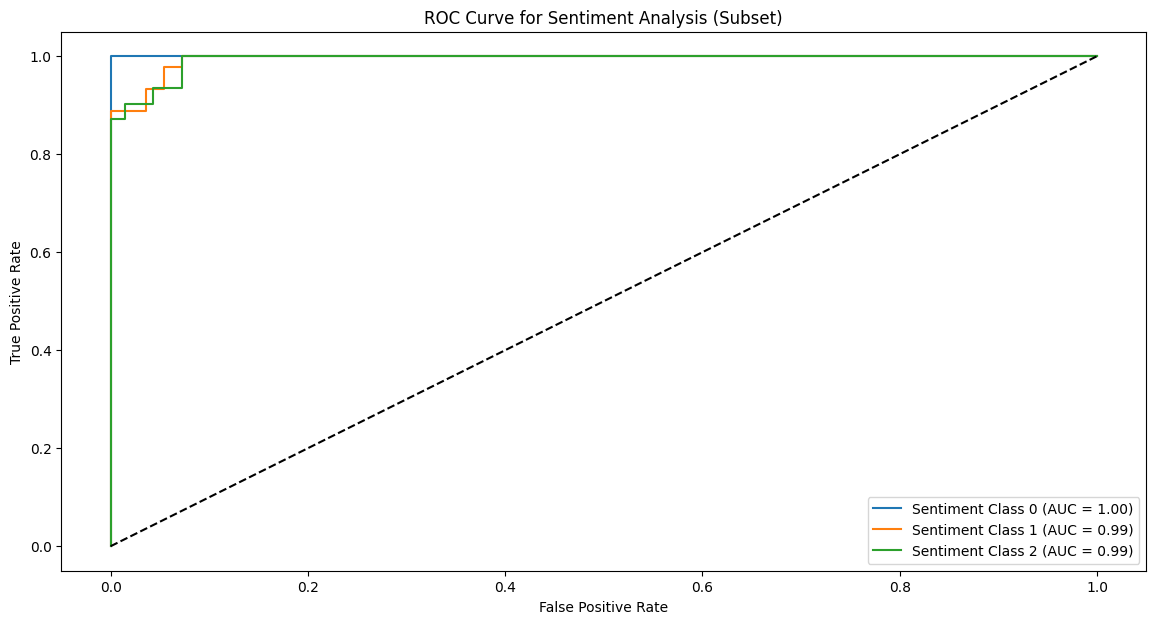

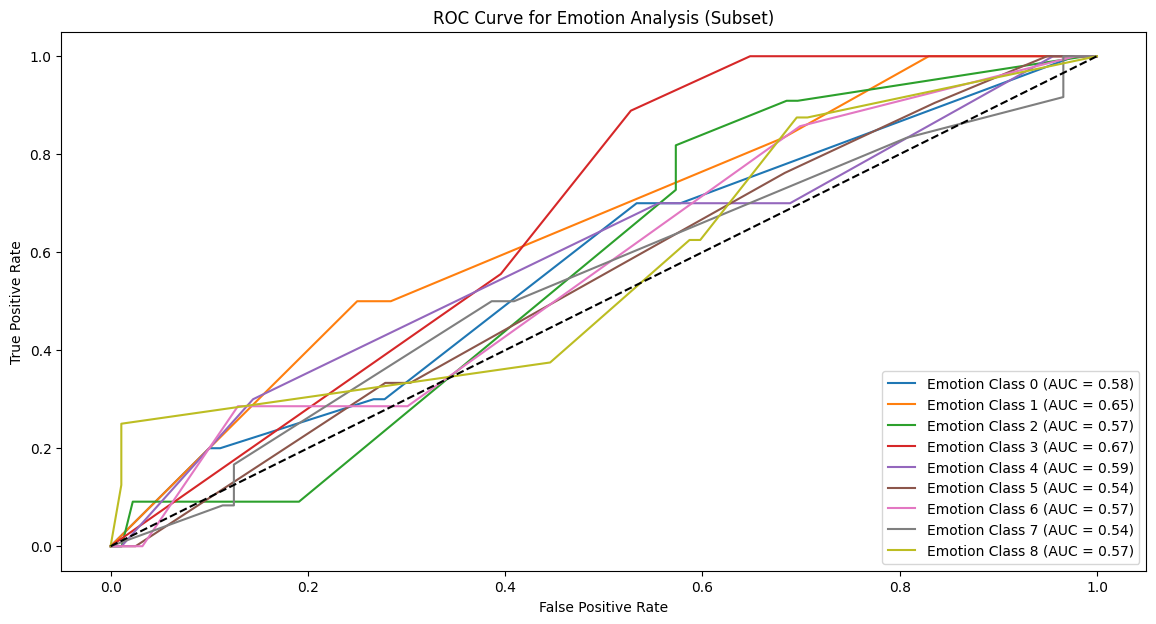

In [25]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Select a subset of the dataset (e.g., 100 random samples)
subset_size = 100
subset_data = poetry_data_balanced.sample(n=subset_size, random_state=42)

# True sentiment and emotion labels
true_sentiments = subset_data['Sentiment'].tolist()
true_emotions = subset_data['Emotion'].tolist()

# Convert true labels to numerical format (based on the mappings)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

true_sentiments_numerical = [sentiment_label_mapping[s] for s in true_sentiments]
true_emotions_numerical = [emotion_label_mapping[e] for e in true_emotions]

# Tokenize the sentences
sentiment_inputs = sentiment_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Create TensorDatasets for sentiment and emotion
sentiment_dataset = TensorDataset(sentiment_inputs['input_ids'], sentiment_inputs['attention_mask'], torch.tensor(true_sentiments_numerical))
emotion_dataset = TensorDataset(emotion_inputs['input_ids'], emotion_inputs['attention_mask'], torch.tensor(true_emotions_numerical))

# Create DataLoaders with smaller batch sizes to reduce memory usage
sentiment_loader = DataLoader(sentiment_dataset, batch_size=16)
emotion_loader = DataLoader(emotion_dataset, batch_size=16)

# Collect predicted probabilities for sentiment
sentiment_probabilities = []
with torch.no_grad():
    for batch in sentiment_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
        sentiment_probabilities.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

sentiment_probabilities = np.concatenate(sentiment_probabilities)

# Collect predicted probabilities for emotion
emotion_probabilities = []
with torch.no_grad():
    for batch in emotion_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = emotion_model(input_ids=input_ids, attention_mask=attention_mask)
        emotion_probabilities.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

emotion_probabilities = np.concatenate(emotion_probabilities)

# For ROC/AUC, we need to binarize the labels in a one-vs-rest approach
# Binarize the sentiment labels (assuming 3 classes: Negative, Neutral, Positive)
true_labels_sentiment_binarized = label_binarize(true_sentiments_numerical, classes=[0, 1, 2])

# Binarize the emotion labels (based on the number of emotion classes)
true_labels_emotion_binarized = label_binarize(true_emotions_numerical, classes=[i for i in range(len(emotion_label_mapping))])

# Plot ROC curve for Sentiment
fpr_sentiment = dict()
tpr_sentiment = dict()
roc_auc_sentiment = dict()

for i in range(3):  # Assuming 3 sentiment classes
    fpr_sentiment[i], tpr_sentiment[i], _ = roc_curve(true_labels_sentiment_binarized[:, i], sentiment_probabilities[:, i])
    roc_auc_sentiment[i] = auc(fpr_sentiment[i], tpr_sentiment[i])

plt.figure(figsize=(14, 7))
for i in range(3):
    plt.plot(fpr_sentiment[i], tpr_sentiment[i], label=f'Sentiment Class {i} (AUC = {roc_auc_sentiment[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sentiment Analysis (Subset)')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for Emotion
fpr_emotion = dict()
tpr_emotion = dict()
roc_auc_emotion = dict()

for i in range(len(emotion_label_mapping)):  # Based on the number of emotion classes
    fpr_emotion[i], tpr_emotion[i], _ = roc_curve(true_labels_emotion_binarized[:, i], emotion_probabilities[:, i])
    roc_auc_emotion[i] = auc(fpr_emotion[i], tpr_emotion[i])

plt.figure(figsize=(14, 7))
for i in range(len(emotion_label_mapping)):
    plt.plot(fpr_emotion[i], tpr_emotion[i], label=f'Emotion Class {i} (AUC = {roc_auc_emotion[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Emotion Analysis (Subset)')
plt.legend(loc="lower right")
plt.show()


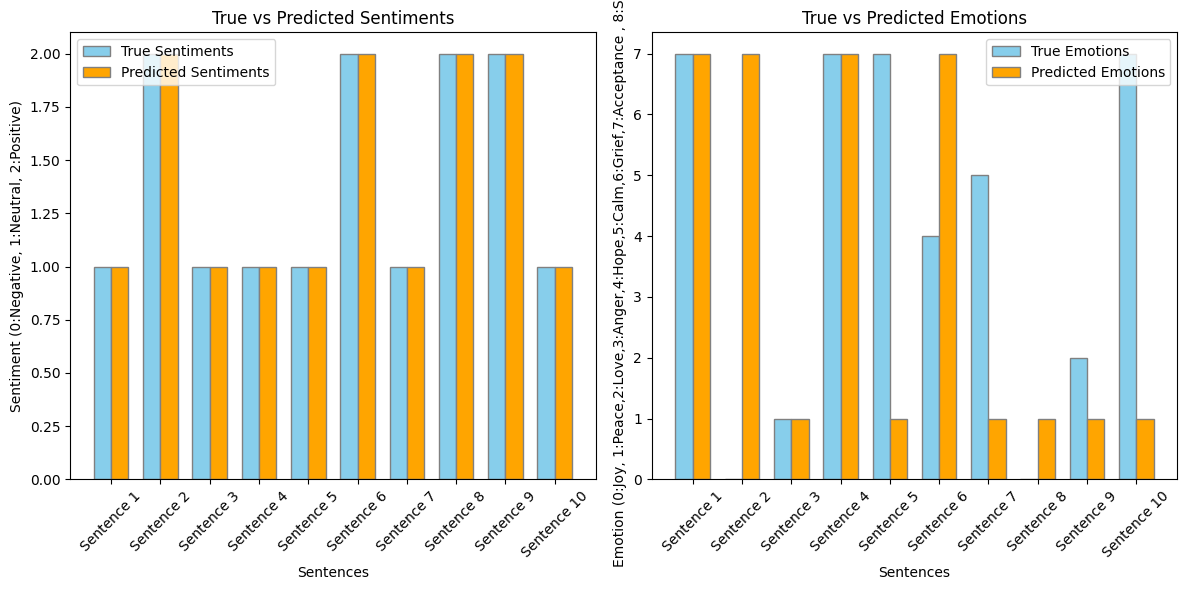

In [24]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Randomly select 10 sentences from your dataset
# Assuming `poetry_data_balanced` is a pandas DataFrame containing your dataset
random_sentences = poetry_data_balanced.sample(n=10, random_state=42)

# True sentiment and emotion labels
true_sentiments = random_sentences['Sentiment'].tolist()
true_emotions = random_sentences['Emotion'].tolist()

# Convert true labels to numerical format (based on the mappings)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

true_sentiments_numerical = [sentiment_label_mapping[s] for s in true_sentiments]
true_emotions_numerical = [emotion_label_mapping[e] for e in true_emotions]

# Tokenize the sentences
sentiment_inputs = sentiment_tokenizer(random_sentences['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(random_sentences['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Get predicted values for sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Get predicted values for emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

# Now create a double bar graph comparing true vs predicted values for both sentiment and emotion

# Plot double bar graph for sentiment
categories = [f"Sentence {i+1}" for i in range(len(random_sentences))]
bar_width = 0.35
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))

# Sentiment plot
plt.subplot(1, 2, 1)
plt.bar(r1, true_sentiments_numerical, color='skyblue', width=bar_width, edgecolor='grey', label='True Sentiments')
plt.bar(r2, sentiment_predictions, color='orange', width=bar_width, edgecolor='grey', label='Predicted Sentiments')
plt.xlabel('Sentences')
plt.ylabel('Sentiment (0:Negative, 1:Neutral, 2:Positive)')
plt.title('True vs Predicted Sentiments')
plt.xticks([r + bar_width / 2 for r in range(len(categories))], categories, rotation=45)
plt.legend()

# Plot double bar graph for emotion
plt.subplot(1, 2, 2)
plt.bar(r1, true_emotions_numerical, color='skyblue', width=bar_width, edgecolor='grey', label='True Emotions')
plt.bar(r2, emotion_predictions, color='orange', width=bar_width, edgecolor='grey', label='Predicted Emotions')
plt.xlabel('Sentences')
plt.ylabel('Emotion (0:Joy, 1:Peace,2:Love,3:Anger,4:Hope,5:Calm,6:Grief,7:Acceptance , 8:Sadness)')
plt.title('True vs Predicted Emotions')
plt.xticks([r + bar_width / 2 for r in range(len(categories))], categories, rotation=45)
plt.legend()

# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.show()


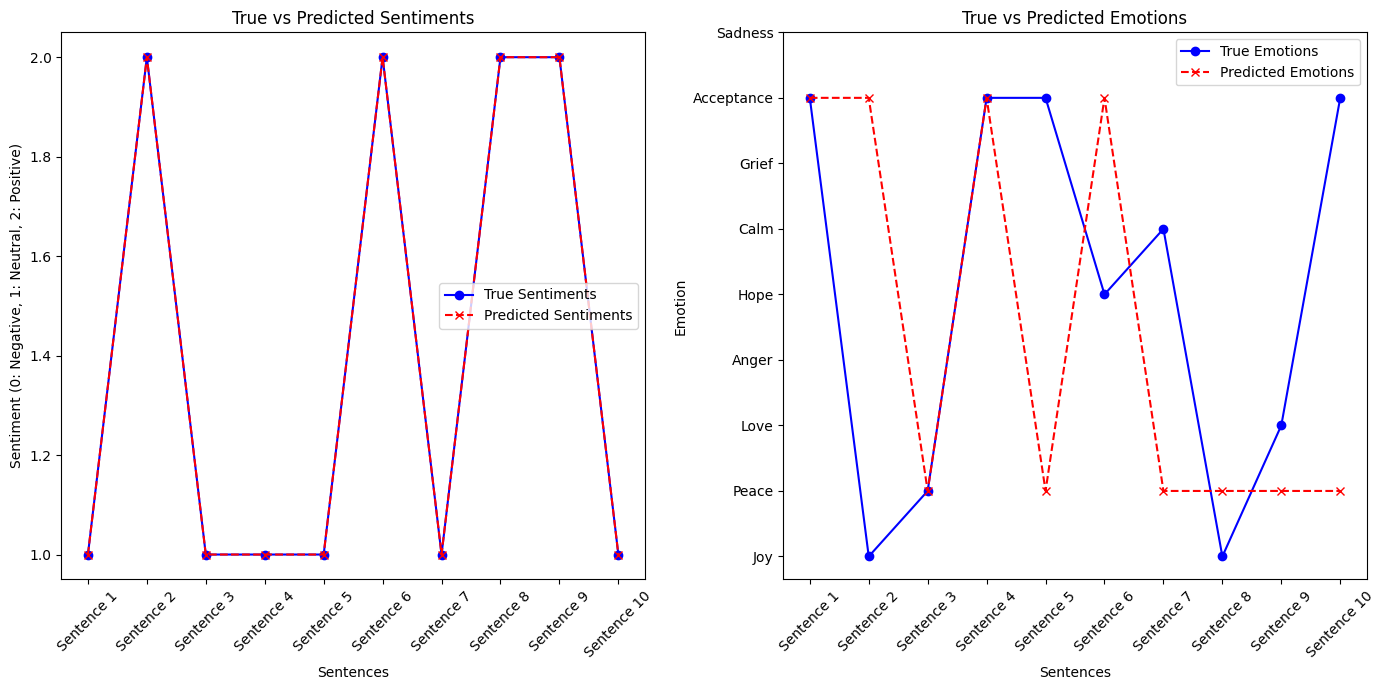

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset

# Load fine-tuned models
sentiment_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_sentiment_model')
emotion_model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_emotion_model')

# Load tokenizers
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emotion_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Move models to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_model.to(device)
emotion_model.to(device)

# Select a subset of the dataset (e.g., 10 random samples)
subset_size = 10
subset_data = poetry_data_balanced.sample(n=subset_size, random_state=42)

# True sentiment and emotion labels
true_sentiments = subset_data['Sentiment'].tolist()
true_emotions = subset_data['Emotion'].tolist()

# Convert true labels to numerical format (based on the mappings)
sentiment_label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

emotion_label_mapping = {
    'Joy': 0,
    'Peace': 1,
    'Love': 2,
    'Anger': 3,
    'Hope': 4,
    'Calm': 5,
    'Grief': 6,
    'Acceptance': 7,
    'Sadness': 8,
}

true_sentiments_numerical = [sentiment_label_mapping[s] for s in true_sentiments]
true_emotions_numerical = [emotion_label_mapping[e] for e in true_emotions]

# Tokenize the sentences
sentiment_inputs = sentiment_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
emotion_inputs = emotion_tokenizer(subset_data['Sentence'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

# Get predicted values for sentiment
with torch.no_grad():
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment_predictions = sentiment_outputs.logits.argmax(dim=-1).cpu().numpy()

# Get predicted values for emotion
with torch.no_grad():
    emotion_outputs = emotion_model(**emotion_inputs)
    emotion_predictions = emotion_outputs.logits.argmax(dim=-1).cpu().numpy()

# Plot line graph comparing true vs. predicted values for both sentiment and emotion

# Set up categories for labels
categories = [f"Sentence {i+1}" for i in range(len(subset_data))]

# Create the emotion label mapping for the y-axis
emotion_names = ['Joy', 'Peace', 'Love', 'Anger', 'Hope', 'Calm', 'Grief', 'Acceptance', 'Sadness']

plt.figure(figsize=(14, 7))

# Line graph for sentiment
plt.subplot(1, 2, 1)
plt.plot(categories, true_sentiments_numerical, marker='o', color='blue', label='True Sentiments')
plt.plot(categories, sentiment_predictions, marker='x', color='red', linestyle='--', label='Predicted Sentiments')
plt.xlabel('Sentences')
plt.ylabel('Sentiment (0: Negative, 1: Neutral, 2: Positive)')
plt.title('True vs Predicted Sentiments')
plt.xticks(rotation=45)
plt.legend()

# Line graph for emotion with emotion names on the y-axis
plt.subplot(1, 2, 2)
plt.plot(categories, true_emotions_numerical, marker='o', color='blue', label='True Emotions')
plt.plot(categories, emotion_predictions, marker='x', color='red', linestyle='--', label='Predicted Emotions')
plt.xlabel('Sentences')
plt.ylabel('Emotion')
plt.yticks(ticks=np.arange(len(emotion_names)), labels=emotion_names)  # Show emotion names on the y-axis
plt.title('True vs Predicted Emotions')
plt.xticks(rotation=45)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
